# How to get adversarially robust SVM
In this notebook,
we try different methods for training adversarially robust SVMs.
The question we want to answer is

> **Can robustly trained (standard) kernel machines match robust NN performance?**

By standard, we mean standardly used kernels like the RBF or Laplace kernels.

Even though the question asks about kernel machines,
we believe SVMs are pretty representative of kernel machines, and that results obtained for standard SVMs would be indicative of the story of general kernel machines.

We will try three techniques for training robust SVMs:

1. Varying the C parameter, which controls the penalty on the RKHS norm of the decision function.
2. Gradient descent on min-max adversarial loss.
3. Throwing out non-robust features.

One way to check our results is by comparing with the results from Appendix E of https://arxiv.org/pdf/1805.12152.pdf.

### Load dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from sklearn import svm

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

In [3]:
import sys
sys.path.append("..")

from adversarial_ntks.dataset import get_np_data, plot_sample_data
from adversarial_ntks import jsvc
from adversarial_ntks import attacks

### Load data

In [4]:
mnist = {}
mnist["clf"] = {}
mnist["train"] = {}
mnist["test"] = {}
mnist["train"]["X"], mnist["train"]["Y"] = get_np_data(
    name="mnist", split="train[:2000]", binary_labels=True, flatten=True
)
mnist["test"]["X"], mnist["test"]["Y"] = get_np_data(
    name="mnist", split="test[:100]", binary_labels=True, flatten=True
)

In [5]:
def clf_acc(clf, X, Y):
    return (clf.predict(X) == Y).mean()

# How does C impact adversarial accuracy?

### Linear models

In [6]:
%%time
mnist["clf"]["linear"] = []
for C in[1e-4, 3e-4, 1e-3, 3e-2,  1e-2, 1e-1, 1e0]:
    clf = svm.SVC(C=C, kernel="linear") \
             .fit(mnist["train"]["X"], mnist["train"]["Y"])

    test_acc = clf_acc(clf, mnist["test"]["X"], mnist["test"]["Y"])
    print(f"C={C:<7} test_acc={test_acc}")
    
    mnist["clf"]["linear"].append(
        dict(clf=clf, C=C, test_acc=test_acc)
    )

C=0.0001  test_acc=0.46
C=0.0003  test_acc=0.73
C=0.001   test_acc=0.78
C=0.03    test_acc=0.78
C=0.01    test_acc=0.76
C=0.1     test_acc=0.74
C=1.0     test_acc=0.77
CPU times: user 4.59 s, sys: 33.9 ms, total: 4.62 s
Wall time: 4.62 s


In [7]:
%%time
for d in mnist["clf"]["linear"]:
    d["X_adv"] = attacks.pgd(
        X=jnp.array(mnist["test"]["X"]),
        Y=jnp.array(mnist["test"]["Y"]),
        grad_func=lambda X: jsvc.grad_decision_function(d["clf"], X),
        eps=0.15, eps_norm=np.inf,
        step_size=0.01, step_norm=np.inf,
        num_steps=20
    )
    d["X_diff"] = d["X_adv"] - mnist["test"]["X"]
    d["test_acc_adv"] = clf_acc(d["clf"], d["X_adv"], mnist["test"]["Y"])
    
    print(f"C={d['C']:<7} test_acc={d['test_acc']:<4} test_acc_adv={d['test_acc_adv']}")

C=0.0001  test_acc=0.46 test_acc_adv=0.37
C=0.0003  test_acc=0.73 test_acc_adv=0.19
C=0.001   test_acc=0.78 test_acc_adv=0.15
C=0.03    test_acc=0.78 test_acc_adv=0.0
C=0.01    test_acc=0.76 test_acc_adv=0.01
C=0.1     test_acc=0.74 test_acc_adv=0.0
C=1.0     test_acc=0.77 test_acc_adv=0.0
CPU times: user 5.01 s, sys: 307 ms, total: 5.31 s
Wall time: 1.31 s


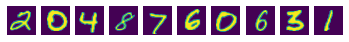

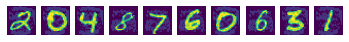

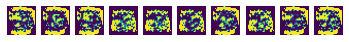

In [8]:
plot_sample_data(mnist["test"]["X"][:10])
plot_sample_data(mnist["clf"]["linear"][3]["X_adv"][:10])
plot_sample_data(mnist["clf"]["linear"][3]["X_diff"][:10])

### RBF models

In [9]:
%%time
mnist["clf"]["rbf"] = []
for C in[1e-2, 1e-1, 1e0, 5, 1e1]:
    clf = svm.SVC(C=C, kernel="rbf") \
             .fit(mnist["train"]["X"], mnist["train"]["Y"])

    test_acc = clf_acc(clf, mnist["test"]["X"], mnist["test"]["Y"])
    print(f"C={C:<7} test_acc={test_acc}")
    
    mnist["clf"]["rbf"].append(
        dict(clf=clf, C=C, test_acc=test_acc)
    )

C=0.01    test_acc=0.43
C=0.1     test_acc=0.84
C=1.0     test_acc=0.94
C=5       test_acc=0.96
C=10.0    test_acc=0.94
CPU times: user 3.4 s, sys: 12.7 ms, total: 3.41 s
Wall time: 3.41 s


In [10]:
%%time
for d in mnist["clf"]["rbf"]:
    d["X_adv"] = attacks.pgd(
        X=jnp.array(mnist["test"]["X"]),
        Y=jnp.array(mnist["test"]["Y"]),
        grad_func=lambda X: jsvc.grad_decision_function(d["clf"], X),
        eps=0.15, eps_norm=np.inf,
        step_size=0.01, step_norm=np.inf,
        num_steps=20
    )
    d["X_diff"] = d["X_adv"] - mnist["test"]["X"]
    d["test_acc_adv"] = clf_acc(d["clf"], d["X_adv"], mnist["test"]["Y"])
    
    print(f"C={d['C']:<7} test_acc={d['test_acc']:<4} test_acc_adv={d['test_acc_adv']}")

C=0.01    test_acc=0.43 test_acc_adv=0.43
C=0.1     test_acc=0.84 test_acc_adv=0.32
C=1.0     test_acc=0.94 test_acc_adv=0.22
C=5       test_acc=0.96 test_acc_adv=0.13
C=10.0    test_acc=0.94 test_acc_adv=0.1
CPU times: user 1min 4s, sys: 28.6 s, total: 1min 33s
Wall time: 27.9 s


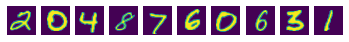

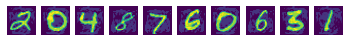

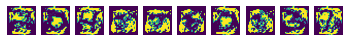

In [11]:
plot_sample_data(mnist["test"]["X"][:10])
plot_sample_data(mnist["clf"]["rbf"][3]["X_adv"][:10])
plot_sample_data(mnist["clf"]["rbf"][3]["X_diff"][:10])

# G.D. on min-max adv. loss (TODO)

# Throwing out non-robust features (TODO)